In [1]:
import io
import os
import polars as pl
import pandas as pd
import httpx
from typing import List, Mapping, Tuple, Union

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Set width of column for tables in polars
pl.Config.set_fmt_str_lengths(100)


polars.config.Config

# 1. Get All CES Series using Polars
- Polars is used instead; Pandas library execution would take signifinicant longer time especially in the read operation

In [2]:
# Set global variables
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3",
    "Accept-Language": "en-US,en;q=0.9",
}
BLS_PATH_URL = "https://download.bls.gov/pub/time.series"

In [3]:
# Helper functions
def get_response_from_url(url: str, headers: Mapping[str, str]) -> str:
    response = httpx.get(url, headers=headers)
    response.raise_for_status()
    return response.text

def build_url(id: str) -> str:
    # The key to access metadata for ALL CES Series
    key = "ce.data.0.AllCESSeries"
    return f"{BLS_PATH_URL}/{id}/{key}"

def parse_csv(obj: str) -> pl.DataFrame:
    # Parsing CSV with pandas pd.read_csv takes longer time, using polars for faster read operation
    data = pl.read_csv(io.StringIO(obj), separator="\t", infer_schema_length=False)
    data.columns = [col.strip() for col in data.columns]
    return data

def map_ce_series_name(data: pl.DataFrame, series_id: str) -> pl.DataFrame:
    # Get the ce series name mapping
    obj = get_response_from_url(
        f"{BLS_PATH_URL}/{series_id}/ce.series",
        headers=HEADERS,
    )
    # Parse the series id to series name mapping
    ce_series = (
        parse_csv(obj)
        .with_columns(pl.col("series_id").str.strip())
        .select(["series_id", "series_title"])
    )
    series_id_to_name = {}
    for row in ce_series.iter_rows():
        series_id_to_name[row[0]] = row[1]

    data = (
        data.with_columns(
            pl.col("series_id").map_dict(series_id_to_name).alias("series_name")
        )
        .with_columns(
            pl.col("series_name")
            .str.replace_all(" ", "_")
            .str.replace_all(",", "")
            .str.replace_all("-", "_")
            .str.replace_all("not_seasonally_adjusted", "nsa")
            .str.replace_all("seasonally_adjusted", "sa")
            .str.to_lowercase()
        )
        .select(
            pl.col("series_name"),
            pl.all().exclude(["series_name", "series_id"]),
        )
    )
    return data

In [4]:
def extractor_all_series(series_id: str = "ce") -> pl.DataFrame:
    """
    Extracts time series data for the given series ID from US Labour of Statistics.

    Parameters:
        series_id (str): The series ID for which to extract time series data.

    Returns:
        pl.DataFrame: A Polars DataFrame containing the extracted time series data.
        
    This function retrieves time series data for the specified series ID using the
    `get_response_from_url()` function to fetch the data from a URL. The retrieved
    data is then parsed into a Polars DataFrame using the `parse_csv()` function.
    
    The function proceeds to perform the following data transformations:
    1. Removes rows with "M13" as the period.
    2. Parses the "year" and "period" columns and creates a new "time" column with datetime format.
    3. Selects the "series_id", "time", and "value" columns.
    4. Shrinks the data types of columns to optimize memory usage.
    
    If the `series_id` is "ce", the function further processes the data using the
    `map_ce_series_name()` function to map the series names based on the specified series ID.
    
    The resulting Polars DataFrame contains the extracted time series data ready for analysis.
    """
    obj = get_response_from_url(
        build_url(series_id),
        headers=HEADERS,
    )
    raw_data = parse_csv(obj)
    
    data = (
        raw_data
        # Remove M13 as period
        .filter(pl.col("period") != "M13")
        # Parse datetime col
        .with_columns(
            [
                (pl.col("year") + pl.col("period"))
                .alias("time")
                .str.to_datetime("%YM%m", strict=False),
            ]
        )
        .select(
            [
                pl.col("series_id").str.strip(),
                pl.col("time"),
                pl.col("value").str.strip().cast(pl.Float64),
            ]
        )
        .select(pl.all().shrink_dtype())
    )

    if series_id == "ce":
        data = map_ce_series_name(data=data, series_id=series_id)

    return data

## Extract the data

In [5]:
bls_data = extractor_all_series("ce")

## Snapshot of the extracted data

In [6]:
print(f"Total rows for all CES Series: {len(bls_data)}")
print(f"Snapshot of the data extracted: {bls_data.head()}")

Total rows for all CES Series: 7895859
Snapshot of the data extracted: shape: (5, 3)
┌──────────────────────────────────────────┬─────────────────────┬─────────┐
│ series_name                              ┆ time                ┆ value   │
│ ---                                      ┆ ---                 ┆ ---     │
│ str                                      ┆ datetime[μs]        ┆ f32     │
╞══════════════════════════════════════════╪═════════════════════╪═════════╡
│ all_employees_thousands_total_nonfarm_sa ┆ 1939-01-01 00:00:00 ┆ 29923.0 │
│ all_employees_thousands_total_nonfarm_sa ┆ 1939-02-01 00:00:00 ┆ 30100.0 │
│ all_employees_thousands_total_nonfarm_sa ┆ 1939-03-01 00:00:00 ┆ 30280.0 │
│ all_employees_thousands_total_nonfarm_sa ┆ 1939-04-01 00:00:00 ┆ 30094.0 │
│ all_employees_thousands_total_nonfarm_sa ┆ 1939-05-01 00:00:00 ┆ 30299.0 │
└──────────────────────────────────────────┴─────────────────────┴─────────┘


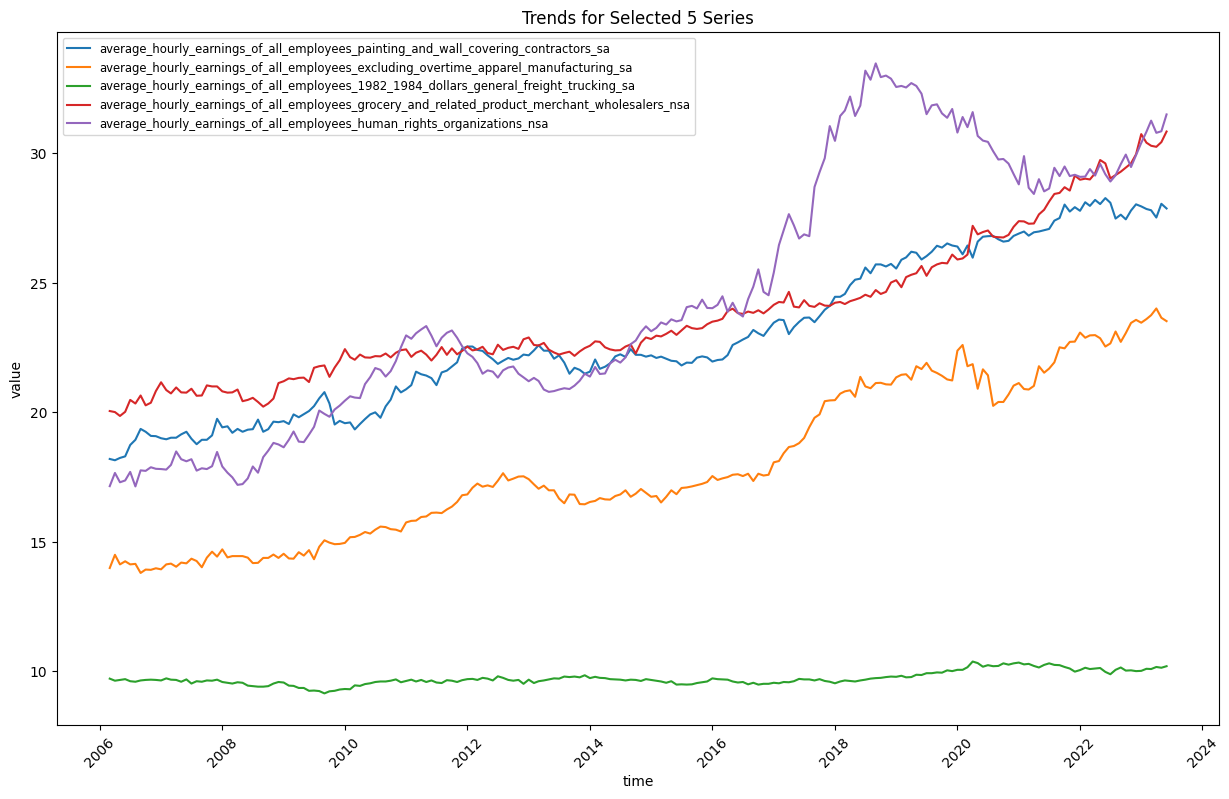

In [7]:
plt.figure(figsize=(15, 9))
# Filter data by selected series
selected_series = [x for x in bls_data.get_column("series_name").unique() if "average_hourly_earnings_of_all_employees" in x][:5]
viz_data = bls_data.filter(pl.col("series_name").is_in(selected_series))
sns.lineplot(data=viz_data, x='time', y='value', hue="series_name")

# Add chart title
plt.title("Trends for Selected 5 Series")

# Remove legend title and reduce font
plt.legend(title="", fontsize="small")
# Rotates x-axis labels for better visibility
plt.xticks(rotation=45)  

plt.show()

## Export the data to csv

In [8]:
from datetime import datetime
# Get today's date for timestamp as export
dt_today = str(datetime.now().date())

# Export to local directory
path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
bls_data.write_csv(f"{path}/dataset/bls_{dt_today}.csv")

# Visualisation using 5 time series 

# 2. Extract one of the popular time series using CES Public Open API using Pandas
- https://data.bls.gov/cgi-bin/surveymost?bls

In [9]:
import requests
import json
import pandas as pd
import re

In [10]:
# Helper functions
def process_series_data(series):
    data_rows = []
    seriesId = series["seriesID"]
    for item in series["data"]:
        year = item["year"]
        period = item["period"]
        value = item["value"]
        footnotes = ""
        for footnote in item["footnotes"]:
            if footnote:
                footnotes = footnotes + footnote["text"] + ","

        if "M01" <= period <= "M12":
            data_rows.append([seriesId, year, period, value, footnotes[0:-1]])

    return data_rows

def json_to_dataframe(json_data) -> pd.DataFrame:
    if "Results" not in json_data or "series" not in json_data["Results"]:
        raise ValueError(json_data['message'])
    
    data_rows = []
    for series in json_data["Results"]["series"]:
        data_rows.extend(process_series_data(series))

    df = pd.DataFrame(
        data_rows, columns=["series id", "year", "period", "value", "footnotes"]
    )
    return df


def parse_datetime(df: pd.DataFrame) -> pd.DataFrame:
    df["time"] = pd.to_datetime(df["year"] + "-" + df["period"].str[-2:] + "-01")
    return df


def to_snakecase(text) -> str:
    return text.lower().replace(" ", "_")


def remove_special_characters(text)-> str:
    # Remove parentheses, hyphens, and square brackets
    cleaned_text = re.sub(r"[\(\)\-\[\]]", "", text)
    return cleaned_text

In [11]:
# Main extractor using v1 API 
def get_bls_series(series_id_to_name: Mapping[str, str]) -> pd.DataFrame:
    """
    Retrieves time series data for the specified series IDs from the BLS API.

    Parameters:
        series_id_to_name (Mapping[str, str]): A mapping of series IDs to their corresponding names.
                                              The keys are series IDs (str), and the values are
                                              the respective series names (str).

    Returns:
        pd.DataFrame: A pandas DataFrame containing the extracted time series data.

    This function uses the BLS API to fetch time series data for multiple series IDs based on the
    provided mapping of series IDs to names. The function performs the following steps to obtain
    and preprocess the data:

    1. Prepares the request data as a JSON string with the specified series IDs, start year, and end year.
    2. Sends a POST request to the BLS API to fetch the time series data in JSON format.
    3. Converts the JSON data to a pandas DataFrame using the json_to_dataframe function.
    4. Preprocesses the DataFrame by parsing the datetime, replacing series IDs with series names,
       converting column names to snake_case, renaming the "series_id" column to "series_name",
       converting series_name values to snakecase, and removing special characters.
    5. Reshapes the DataFrame to keep only the desired columns ("series_name", "time", "value"),
       and sets "series_name" as the index of the DataFrame.

    The provided mapping series_id_to_name allows you to retrieve data for multiple series IDs
    simultaneously. The resulting DataFrame contains the time series data ready for further analysis
    or visualization.
    """
    headers = {"Content-type": "application/json"}
    # Prepare the request data as a JSON string
    # NOTE: The start year and end year is set at 2013 and 2023 respectively
    data = json.dumps(
        {"seriesid": list(series_id_to_name.keys()), "startyear": "2013", "endyear": "2023"}
    )
    # Send a POST request to the BLS API to get the JSON data
    p = requests.post(
        "https://api.bls.gov/publicAPI/v1/timeseries/data/", data=data, headers=headers
    )
    # Load the json data
    json_data = json.loads(p.text)
    # Convert json_data to pd.DataFrame
    df = json_to_dataframe(json_data)
    
    # Preprocessing data into desired format
    data = (
        # Parse datetime to YY-MM-DD format
        parse_datetime(df)
        # Replace series id with series name
        .replace({"series id": series_id_to_name})
        # Make all column name to snake_case
        .rename(columns=lambda x: to_snakecase(x))
        # Replace name for column "series_id" to "series_name"
        .rename(columns={"series_id": "series_name"})
        # Turn all values in series_name to snakecase and remove special characters
        .assign(
            series_id=lambda x: x["series_name"]
            .apply(to_snakecase)
            .apply(remove_special_characters)
        )
        # Reshape df to desired features only
        .pipe(lambda df: df.loc[:, ["series_name", "time", "value"]])
        .set_index("series_name")
        .astype({"value": "Float64"})
    )
    return data

## Run the extractor

In [12]:
# Set series id and series name 
SERIES_ID_TO_NAME = {"LNS14000000": "Unemployment Rate (Seasonally Adjusted)"}
# Extract time series using Public Data V1 API
bls_series = get_bls_series(series_id_to_name=SERIES_ID_TO_NAME)

## Snapshot of the extracted data

In [13]:
print(f"Total rows for time series since 2013: {len(bls_series)}")
print(bls_series.dtypes)
print(f"Snapshot of the data extracted: {bls_series}")

Total rows for time series since 2013: 120
time     datetime64[ns]
value           Float64
dtype: object
Snapshot of the data extracted:                                               time  value
series_name                                              
Unemployment Rate (Seasonally Adjusted) 2022-12-01    3.5
Unemployment Rate (Seasonally Adjusted) 2022-11-01    3.6
Unemployment Rate (Seasonally Adjusted) 2022-10-01    3.7
Unemployment Rate (Seasonally Adjusted) 2022-09-01    3.5
Unemployment Rate (Seasonally Adjusted) 2022-08-01    3.7
...                                            ...    ...
Unemployment Rate (Seasonally Adjusted) 2013-05-01    7.5
Unemployment Rate (Seasonally Adjusted) 2013-04-01    7.6
Unemployment Rate (Seasonally Adjusted) 2013-03-01    7.5
Unemployment Rate (Seasonally Adjusted) 2013-02-01    7.7
Unemployment Rate (Seasonally Adjusted) 2013-01-01    8.0

[120 rows x 2 columns]


## Export to CSV

In [14]:
from datetime import datetime
# Get today's date for timestamp as export
dt_today = str(datetime.now().date())

# Export to local directory
path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
series_name = "_".join(SERIES_ID_TO_NAME.keys())
bls_series.to_csv(f"{path}/dataset/bls_{series_name}_{dt_today}.csv")

## Visualisation - Using LNS14000000 Unempployment Rate

In [61]:
# Prepare df for viz
series_data = bls_series.reset_index()
# Find min and max index for datetime (x-coord for annotate)
max_index = series_data["value"].idxmax()
min_index = series_data["value"].idxmin()
# Find min and max value for y-coord (for annotation)
max_value = series_data["value"].max()
min_value = series_data["value"].min()

Text(-20, -20, 'Lowest - 3.5')

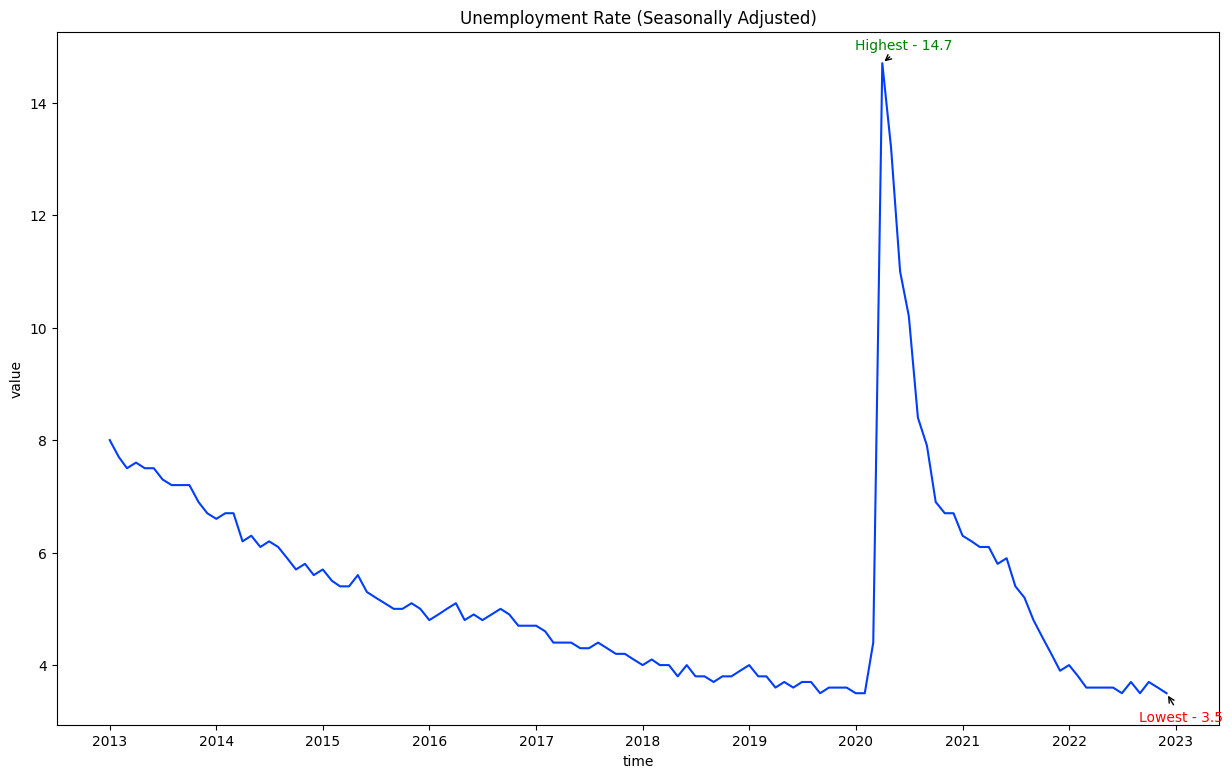

In [62]:
plt.figure(figsize=(15, 9))
sns.lineplot(data=bls_series, x="time", y="value", color = "#003DFD")

# Add chart title
plt.title(", ".join(SERIES_ID_TO_NAME.values()))

plt.annotate(f'Highest - {max_value}', (series_data["time"][max_index], max_value), xytext=(-20, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->'), color='green')
plt.annotate(f'Lowest - {min_value}', (series_data["time"][min_index], min_value), xytext=(-20, -20), textcoords='offset points', arrowprops=dict(arrowstyle='->'), color='red')